In [1]:
# Required imports
import json
import re
import zipfile as zp
import pandas as pd
import numpy as np
import emoji
import random
import pygal

In [2]:
# Generating data
import matplotlib

In [3]:
# Loading data from csv for faster testing
# messages_table = pd.read_csv('przykladowe_dane.csv', index_col=0, parse_dates=['time'])
my_name = 'Jacek Stasiak'

In [4]:

def get_structure(zip):
    folders = {}
    for i in zip.namelist():
        entry = i.split('/')
        last = entry[-1]
        outer = folders
        for j in entry:
            if j != '':
                if j != last and j not in outer:
                    outer[j] = {}
                if j == last:
                    if '__files' not in outer:
                        outer['__files'] = []
                    outer['__files'].append((j, i))
                if j != last:
                    outer = outer[j]
    return folders


def get_messages(folder):
    message_files = []
    for i in folder.keys():
        files = folder[i]['__files']
        for i in files:
            if re.match(r'.+\.json', i[0]):
                message_files.append(i[1])
    return message_files


def analyse_file(file):
    # stats = {}
    # js = json.loads(file)
    # people = {}
    # for i in js['messages']:
    #     sender = i['sender_name'].encode('latin1').decode('utf8')
    #     if sender not in people:
    #         people[sender] = 0
    #     people[sender] += 1
    # stats['message_count'] = people
    # return stats
    js = json.loads(file)
    # js = json.loads(file)

    constants = [js['title'].encode('latin1').decode('utf8'), js['thread_type']] # wartości które są stałe dla danego czatu, ale może są warte zamieszczenia w tabeli.

    entries = []

    for i in js['messages']:
        content = i.get('content')
        if content:
            content = content.encode('latin1').decode('utf8')
        entries.append([i['sender_name'].encode('latin1').decode('utf8'), i['timestamp_ms'], content])

    entries = np.array(entries)

    data = pd.DataFrame({'conversation': constants[0], 'thread_type': constants[1], 'sender': entries[:, 0], 'time': entries[:, 1], 'content': entries[:, 2]})
    data['time'] = pd.to_datetime(data['time'], unit='ms')

    return data

def gen_pandas_table(zip):
    messages_table = None

    folders = get_structure(zip)
    message_files = get_messages(folders['messages']['inbox'])

    for i in message_files:
        temp_file = zip.getinfo(i)
        # with io.TextIOWrapper(zip.open(temp_file), 'utf-8') as f: # Otwieranie pliku jako tekst, żeby można było odrazu zamienić escapowane znaki na właściwe.
        with zip.open(temp_file) as f:
            stats = analyse_file(f.read())
            if messages_table is None:
                messages_table = stats
            else:
                messages_table = pd.concat([messages_table, stats])

    namefile = folders['profile_information']['__files'][0][1]
    username = ""
    with zip.open(namefile) as f:
        data = json.loads(f.read())
        username = data['profile']['name']['full_name'].encode('latin1').decode('utf8')

    return {'table': messages_table, 'username': username}


In [16]:
# zip_path = "/home/jacek/Pobrane/Okon_Slowacki_30_11_2020.zip"
zip_path = "/home/jacek/Pobrane/facebook-jacekstasiak75 222.zip"
# zip_path = "/home/jacek/Pobrane/facebook-janpodkowa98.zip"

data = None
with zp.ZipFile(zip_path) as zip:
    data = gen_pandas_table(zip)
messages_table = data['table']

In [6]:
# print(ord(list(emoji.UNICODE_EMOJI.keys())[0]))
# print(ord(list(emoji.UNICODE_EMOJI.keys())[-2]))
def check_emojis(s):
    found = {}
    if s == None:
        return found
#     print(s)
    for i in s:
        if i in emoji.UNICODE_EMOJI:
            if i in found:
                found[i] += 1
            else:
                found[i] = 1
    return found

def emoji_ranking(data):
    table = data['table']
    my_name = data['username']
    msgs = table[table['sender'] == my_name]['content']
    
    all_emojis = {}
    for i in msgs:
        emojis = check_emojis(i)
        for j in emojis:
            if j in all_emojis:
                all_emojis[j] += 1
            else:
                all_emojis[j] = 1
    emoji_v = []
    emoji_l = []
#     all_emojis = [(k, v) for k, v in sorted(all_emojis.items(), key=lambda i: i[1], reverse=True)]
    for k, v in sorted(all_emojis.items(), key=lambda i: i[1], reverse=True):
        emoji_v.append(v)
        emoji_l.append(k)                             
    
    chart = pygal.Bar(height=len(emoji_l)*20)
    chart.add('', emoji_v)
    chart.x_labels =  list(emoji_l)
    print(emoji_l)
#     chart.render_to_file("emoji_wykres.png")
#     chart.render_to_png("emoji_wykres.png")
#     print( all_emojis[:])
    return chart
                
a = emoji_ranking(data)
# a
# test = '🤔jakis tekst 🤔 🤔 🤔 '
# for i in test:
#     print(i)
    

[]


In [7]:
# Z kim najczęściej piszę (najwięcej wiadomości których autorem nie jestem ja, w konwersacjach które nie są grupą)

def messages_ranking(data, my_name):

    regs = data[(data['thread_type'] == 'Regular') & (data['sender'] == my_name)]
    group = regs.groupby('conversation')

    counts = group['content'].count().sort_values(ascending=False)
    print(counts)
    # chart = pygal.Bar()
    # chart.add('', counts)
    # chart.x_axis = counts.columns
    # chart.render_to_file("wykres4.svg")

    return None

messages_ranking(messages_table, my_name)

Series([], Name: content, dtype: int64)


In [8]:
# Funkcje do analizowania wiadomości

def update_word_freq(words, all_words, num_words, word_stats):
    word_stats[0] += len(words)
    word_stats[1] += 1

    for j in words:
        if j not in all_words:
            all_words[j] = 1
        else:
            all_words[j] += 1
        word_stats[2] += len(j)
        word_stats[3] += 1

# Zwraca 100 najczęstrzych słów, średnią długość zdania, średnią długość słowa
def get_conversation_stats(messages):
    word_frequency = {}

    avg_sentence_len = 0
    n_sentences = 0

    avg_word_len = 0
    n_words = 0

    word_stats = [0] * 4


    for i in messages:
        # print(type(i))
        # if type(i):
        try:
            words = re.findall(r"[\w']+", i)
            words = list(map(lambda a: a.lower(), words))
            update_word_freq(words, word_frequency, num_words, word_stats)
        except Exception:
            pass

    # for i in word_frequency.keys():
    #     print()
    sorted_words = [(k, v) for k, v in sorted(word_frequency.items(), key=lambda i: i[1], reverse=True)]
    # print("100 most common words: ")
    # print(sorted_words[:100])

    # print(word_stats)
    avg_sentence = 0
    avg_word = 0
    try:
        avg_sentence = word_stats[0] / word_stats[1]
        avg_word = word_stats[2] / word_stats[3]
    except Exception:
        pass

    return (sorted_words[:100], avg_sentence, avg_word)
    # print("avg sentence len: {:.2f} words.".format(word_stats[0] / word_stats[1]))
    # print("avg word len: {:.2f} letters.".format(word_stats[2] / word_stats[3]))
    # for


In [9]:
# Średnia liczba słów, długość słowa i 100 najczęstrzych słów.
msgs = messages_table[:]['content'].dropna().astype("string")
# msg_by_person = messages_table[messages_table['thread_type'] == 'Regular' & messages_table['sender'] != my_name].groupby('sender')
msg_by_person = messages_table.groupby('sender')

stats = {}

for person, messages in msg_by_person:
    stats[person] = get_conversation_stats(messages['content'])
    # if person == 'Hubert Domżałowicz':
    #     print(tstat)
    #     for i in messages['content'][:10]:
            # print(i)

# print(stats)
for k, v in stats.items():
    print(k, v[0][:5], v[1:])
# msg_by_person.get_group('Hubert Domżałowicz')

Ahmed Mohamed [] (0, 0)
Aissa Djabri [] (0, 0)
Aleksandra Róża Wołochowicz [] (0, 0)
Alicja Wróblewska [] (0, 0)
Ania Król [] (0, 0)
Ania Mielnik [] (0, 0)
Ania Strojna [] (0, 0)
Anxhela Kumanova [] (0, 0)
Artur Gawrisz [] (0, 0)
Bong Koka Single [] (0, 0)
Car Tycoon [] (0, 0)
Dawid Strzelecki [] (0, 0)
Dominika Kalińska [] (0, 0)
Hubert Barłóg [] (0, 0)
Hubert Krysztofiak [] (0, 0)
Ibrahim Amin [] (0, 0)
Igor Grybek [] (0, 0)
Jakub Wilk [] (0, 0)
Jan Podkowa [] (0, 0)
Johnny Johnson [] (0, 0)
Julia Daszkiewicz [] (0, 0)
Kamila Niemczewska [] (0, 0)
Kasia Obrębska [] (0, 0)
Klaudia Glanert [] (0, 0)
Klaudia Skibiak [] (0, 0)
Limar Limar [] (0, 0)
Lucjan Brzostek [] (0, 0)
Maciej Talar [] (0, 0)
Magda Galikowska [] (0, 0)
Marta Kobierska [] (0, 0)
Marta Lewandowska [] (0, 0)
Martyna Grabowska [] (0, 0)
Martyna Surdyka [] (0, 0)
Marzena Ryńska [] (0, 0)
Mateusz Kotewicz [] (0, 0)
Mateusz Mikołajczak [] (0, 0)
Milena Klim [] (0, 0)
Monika Trupinda [] (0, 0)
Natalia Kapusta [] (0, 0)
Natal

In [10]:
# Kto najszybiej odpowiada

tmsg = messages_table[messages_table['conversation'] == 'Krzysztof Pijanowski']
tmsg.head()

,conversation,thread_type,sender,time,content


In [11]:
indexes = [1, 2, 2, 2, 3, 4, 5, 1, 1, 1, 2, 1, 2, 2, 1]
# values = ["Basin", "Street", "is", "a", "street", "i", "dont", "know", "what", "is", "he", "singing", "there", "so", "yeah"]
values = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve", "thirteen", "fiveteen", "sixteen"]
# len(indexes), len(values)
a = pd.DataFrame({'index': indexes, 'vals': values})
# a.loc[a['indexes'].diff() != 0] # Jeżeli jest kilka takich samych wartości to są one usuwane, ale nie wiem czy pierwsza czy ostatnia, a lepiej żeby była ostatnia
a['index'].diff() != 0

0      True
1      True
2     False
3     False
4      True
5      True
6      True
7      True
8     False
9     False
10     True
11     True
12     True
13    False
14     True
Name: index, dtype: bool

In [19]:
# Przybliżona czas odpowiedzi
messages = messages_table

# zmiany
# time2 na time_elapsed
# sender2 na sender_id
# 
# [::-1] jest dlatego, bo diff odejmuje tak arr[i] - arr[i-1],
# a wiadomości są od najnowszych do najstarszych i większy sens jest to odwrócić,
# nie wiem jak to wytumaczyć, ale w ten sposób pierwsza wiadomość "rozmowy"
# zawiera odstęp od ostatniej rozmowy i jest on np 1 dzień,
# bez [::-1] to ostatnia wiadomość rozmowy miałaby taki długi odstęp.

# sample = messages[messages['conversation'] == '😊Grupa Do Gadania🙊'][['time', 'sender']]
sample = messages[messages['conversation'] == 'Wiktor Kania'][['time', 'sender']]
def determine_avg_reply_time(sample, my_username): # sample to tabela wiadomości. W zamyśle są tam wiadomości tylko 2 użytkowników. (time, sender required)
    # Słownik nazw użytkowników i ich unikalnych indeksów liczbowych.
    senders = {k: v for v, k in enumerate(sample['sender'].unique())}
    
    # Zamiana nazwy użytkownika na unikalnego, bo nie można użyć diff'a na stringach.
    sample['sender2'] = sample['sender'].map(senders) 
    
    # sample['sender2_test'] = sample['sender2'][::-1].diff() # Można usunąć (debug purposes)
    sample['time2'] = sample['time'][::-1].diff() # Czas który upłynął od ostatniej wiadomości.
    
    sample = sample[ (sample['sender2'][::-1].diff() != 0)[::-1]] # Usuwanie kilku wiadomości użytkownika pod rząd. (Nie może przecież odpowiedzieć sam
    # sample.to_csv("dump.csv")
    # sample[:50]
    sample = sample[sample['time2'] <= sample['time2'].mean()] # Odrzucanie wartości które są początkami rozmów. (Długi czas upłynął od ostatniej wiadomości. Improve if know how.)
    # sample = sample[sample['sender'] != data['username']] # Interesuje nas jak szybko ta osoba odpowiada, ale można zamienić i dowiemy się jak szybko my jej odpowiadamy.know how.)
    sample = sample[sample['sender'] != my_username] # Interesuje nas jak szybko ta osoba odpowiada, ale można zamienić i dowiemy się jak szybko my jej odpowiadamy.
    sample['time2'].median(), sample['time2'].std(), sample['time2'].mean() # W sample['time2'] mogą nadal być duże wartości (w moich danych obok średnio 24s na odpowiedź, znalazł się czas 8h), ale wydaje mi się, że median zwraca wiarygodny wynik.
    return sample['time2'].median()

determine_avg_reply_time(sample, data['username'])
# sample
# reply_times = pd.DataFrame();
# convos = messages[messages['thread_type'] == 'Regular'].groupby('conversation')
# for user, msg in convos:
#     print(user, "EEEEEEEEEEEEE")
#     t = pd.DataFrame({'user': [user], 'time': [determine_avg_reply_time(msg.loc[:, ('sender', 'time')], data['username'])]})
#     print(t)
#     reply_times = reply_times.append(t)

# reply_times = reply_times.dropna() # Usuwa osoby które nigdy nie odpowiedziały
# reply_times = reply_times[reply_times['user'] != 'Łukasz Stawicki']

# gr = pygal.HorizontalBar()
# gr.add('', reply_times['time'].astype('int') / 1e9)
# gr.x_labels = list(reply_times['user'])
# gr.human_readable = True
# gr.show_legend = False
# gr.print_values = True
# gr.print_values_position = 'top'
# gr



# sample['sender2'][::-1].diff()
# sample['sender2'].diff()

# sample['time2'].plot()
# sample[sample['time2'] == sample['time2'].max()]
# regs = messages
# group = regs.groupby('conversation')

# group['content'].count().sort_values()


Timedelta('0 days 00:00:17.337000')

In [13]:
# t = pd.Series([
#     '11/12/2020 00:07:02',
#     '11/12/2020 00:01:15',
#     '11/12/2020 00:00:10'
# ], dtype='datetime64[ns]')
# -t.diff()

# messages[messages['thread_type'] == 'Regular'].groupby('conversation')['content'].count().sort_values()
# messages[messages['conversation'] == 'Wiktor Kania']

# t = pd.DataFrame([1, 2, 1, 4, 1, 6, 1, 8])
# t['b'] = t.diff()
# sample['time2'].plot()
# sample['time2'].median()
# sample['time2']
data['table'].to_csv('dump2.csv')

In [14]:
x = pd.DataFrame()
x = x.append(pd.DataFrame({'user': ['tes'], 'time': [12]}))

print(x)
np.nan

  user  time
0  tes    12


nan

In [45]:
# Przybliżona długość rozmowy

sample = messages[messages['conversation'] == 'Wiktor Kania'][['time', 'sender', 'content']]
def determine_conversation_length(sample, my_username): # sample to tabela wiadomości. W zamyśle są tam wiadomości tylko 2 użytkowników. (time, sender required)
    # Słownik nazw użytkowników i ich unikalnych indeksów liczbowych.
    senders = {k: v for v, k in enumerate(sample['sender'].unique())}

    # Zamiana nazwy użytkownika na unikalnego, bo nie można użyć diff'a na stringach.
    sample['sender2'] = sample['sender'].map(senders) 

    # sample['sender2_test'] = sample['sender2'][::-1].diff() # Można usunąć (debug purposes)
    sample['time2'] = sample['time'][::-1].diff() # Czas który upłynął od ostatniej wiadomości.

    # Usuwanie kilku wiadomości użytkownika pod rząd. (Nie może przecież odpowiedzieć sam sobie)
    # sample = sample[ (sample['sender2'][::-1].diff() != 0)[::-1]] 
    # sample[:50]

    # Odrzucanie wartości które są początkami rozmów. (Długi czas upłynął od ostatniej wiadomości. Improve if know how.)
    sample['conversation_start'] = sample['time2'] > sample['time2'].mean()

    conversation_begs = sample.index[sample['time2'] > sample['time2'].mean()].tolist()
    sample.to_csv("dump.csv")

    # indeks końca ostatniej rozmowy to -1
    conversation_begs.insert(0, -1)
    # indeks początku pierwszej rozmowy to len()-1
    conversation_begs.insert(len(conversation_begs), len(sample) - 1)
    conversation_begs
    conversation_lens = [ conversation_begs[i] - conversation_begs[i - 1] for i in range(1, len(conversation_begs)) ]
    return np.array(conversation_lens).mean()

conv_lens = pd.DataFrame();
convos = messages[messages['thread_type'] == 'Regular'].groupby('conversation')
for user, msg in convos:
#     print(user, "EEEEEEEEEEEEE")
    t = pd.DataFrame({'user': [user], 'length': [determine_conversation_length(msg.loc[:, ('sender', 'time')], data['username'])]})
#     print(t)
    conv_lens = conv_lens.append(t)

conv_lens
    
# Interesuje nas jak szybko ta osoba odpowiada, ale można zamienić i dowiemy się jak szybko my jej odpowiadamy.
# sample = sample[sample['sender'] != data['username']] 

# W sample['time2'] mogą nadal być duże wartości (w moich danych obok średnio 24s na odpowiedź, znalazł się czas 8h), ale wydaje mi się, że median zwraca wiarygodny wynik.
# sample['time2'].median(), sample['time2'].std(), sample['time2'].mean() 
# sample



# return sample['time2'].median()

# determine_avg_reply_time(sample, data['username'])

,user,length
0,Adam Mąkiewicz,1.000000
0,Adrian Tuchowski,1.000000
0,Aneta Kopera,1.000000
0,Anita Zając,3.333333
0,Artur Kotlarek,1.500000
0,Damian Bednarek,1.000000
0,Dominik Wojtal,12.666667
0,Grzegorz Stasiak,15.750000
0,Hubert Domżałowicz,14.250000
0,Jacek Stasiak,4.500000


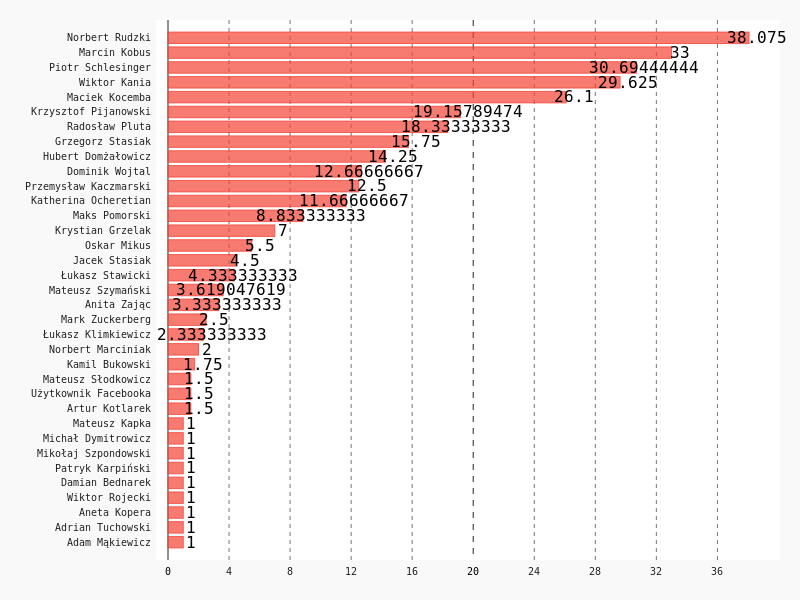

In [55]:
def conversation_length(data): # Skopiowane reply_time, więc nazwy zmiennych nie mają sensu
    messages = data['table']
    reply_times = pd.DataFrame();
    convos = messages[messages['thread_type'] == 'Regular'].groupby('conversation')
    for user, msg in convos:
        t = pd.DataFrame({'user': [user], 'time': [determine_conversation_length(msg.loc[:, ('sender', 'time')], data['username'])]})
    #     print(t)
        reply_times = reply_times.append(t)

#     reply_times = reply_times.dropna() # Usuwa osoby które nigdy nie odpowiedziały :(
    reply_times = reply_times.sort_values(['time'])
    gr = pygal.HorizontalBar()
    gr.add('', reply_times['time'])
    gr.x_labels = list(reply_times['user'])
    gr.human_readable = True
    gr.show_legend = False
    gr.print_values = True
    gr.print_values_position = 'top'

    return gr
conversation_length(data)